In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
from joblib import Parallel, delayed
import joblib
from scipy import stats
%matplotlib inline

In [2]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
ncores = 12
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='2:30:00')
cluster.scale(ncores)
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.12.205.27:46726 Dashboard: http://10.12.205.27:8787/status,Cluster Workers: 12 Cores: 12 Memory: 125.04 GB


### Some useful functions

In [8]:
def get_monthly(data_vars,firstyear=1850):
    """ retrieve monthly data from LENS2 using xarray

    Keyword arguments:
    data_vars -- list of required variables
    firstyear -- first year required for analysis
    
    Notes:
      * you don't need to ask for lat,lon,etc
      * the data are chunked by decade, so:
          firstyear =1995 yields [1990,2014]
      * you must be on casper for this to work (not cheyenne)
      * each 1d variable is 1.3GB/decade, consider taking only what you need :)
    """
    
    # find the ensemble directories
    topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
    mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
    lnd    = '/lnd/proc/tseries/month_1/'
    # establish an ensemble dimension
    ensdim  = xr.DataArray(np.arange(len(mlist)), dims='ens', name='ens')
    ensdim.attrs['long_name']='ensemble number'
    # set up the year strings in each file
    yy1 = max(1850,10*int(firstyear/10))
    years = np.arange(yy1,2011,10)
    year_strs = []
    for year in years:
        if year<2001:
            yy = str(year)+'01-'+str(year+9)+'12'
        else:
            yy = '201001-201412'
        year_strs.append(yy)
        
    #read in the data
    firstvar = True
    for field in data_vars:
        dsets=[]
        for yy,year in zip(year_strs,years):
            paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for mm in mlist]
            ds_temp = xr.open_mfdataset(paths,combine='nested',decode_times=False,
                                        concat_dim=ensdim,parallel=True)[field]
            nmonths = len(ds_temp['time'])
            time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
            ds_temp['time'] = time_vec
            dsets.append(ds_temp)

            if firstvar:    #need to instantiate ds
                firstvar = False
                mm = mlist[0]
                paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for yy in year_strs]
                ds = xr.open_mfdataset(paths,combine='by_coords')
                nmonths = len(ds['time'])
                time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
                ds['time'] = time_vec

        ds[field] =xr.concat(dsets,dim='time')
    return ds

In [9]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [10]:
def detrend(x):
    t  = np.arange(len(x))
    m, b, r, p, std_err = stats.linregress(t,x)
    xdt = x-m*t-b
    return xdt

In [11]:
def regress(x,y):
    m, b, r, p, std_err = stats.linregress(x,y)
    xfit = np.array([x.min(),x.max()])
    yfit = m*xfit+b
    return m,r,xfit,yfit

In [12]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

### Read in the data

In [13]:
%%time
data_vars = ['NBP','SOILLIQ']
firstyear = 2000
cesm2 = get_monthly(data_vars,firstyear)
cesm2['SW']=cesm2['SOILLIQ'].sum(dim='levsoi')


CPU times: user 6.46 s, sys: 1.49 s, total: 7.95 s
Wall time: 34.8 s


### Analysis

In [ ]:
%%time
landarea = cesm2['area']*cesm2['landfrac']
ny = len(np.unique(cesm2['time.year']))
mth_wts = month_wts(ny)

xvar  = 'SW' 
xconv = 1/365*1e-9      #--> TtH2O
yvar  = 'NBP'
yconv = 24*60*60*1e-9   #--> PgC

#calculate global annual mean or sum
xglob = (landarea*cesm2[xvar]).sum(dim=['lat','lon']) 
xann  = xconv*(mth_wts*xglob).groupby('time.year').sum().load()
yglob = (landarea*cesm2[yvar]).sum(dim=['lat','lon']) 
yann  = yconv*(mth_wts*yglob).groupby('time.year').sum().load()

#detrend
xdt = []  
ydt = []
for ee in cesm2['ens']:
    x = xann.sel(ens=ee).values
    y = yann.sel(ens=ee).values
    xdt.append(detrend(x))
    ydt.append(detrend(y))

#regress
regressions = []
for ee in cesm2['ens'].values:
    out = regress(xdt[ee],ydt[ee])
    regressions.append(out)

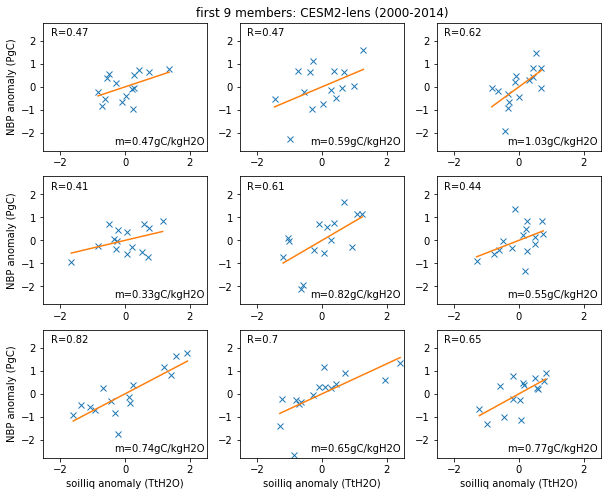

In [67]:
#PLOTTING
xlab = 'soilliq anomaly (TtH2O)'
ylab = 'NBP anomaly (PgC)'
# find x,ylims
nx = 9
xlim = 0
ylim = 0
for ee in range(nx):
    xlim = max(xlim,max(abs(xdt[ee])))
    ylim = max(ylim,max(abs(ydt[ee])))
xlim = 1.05*xlim
ylim = 1.05*ylim
    
plt.figure(figsize=[10,8])
for ee in range(nx):
    m,r,xfit,yfit = regressions[ee]
    plt.subplot(3,3,ee+1)
    plt.plot(xdt[ee],ydt[ee],'x')
    plt.plot(xfit,yfit)
    plt.xlim([-xlim,xlim])
    plt.ylim([-ylim,ylim])
    if (ee>5):
        plt.xlabel(xlab)
    if (ee==0)|(ee==3)|(ee==6):
        plt.ylabel(ylab)
    if (ee==1):
        plt.title('first 9 members: CESM2-lens (2000-2014)')
    plt.text(-0.35,-2.5,'m='+str(np.round(m,2))+'gC/kgH2O')
    plt.text(-2.3,2.2,'R='+str(np.round(r,2)))

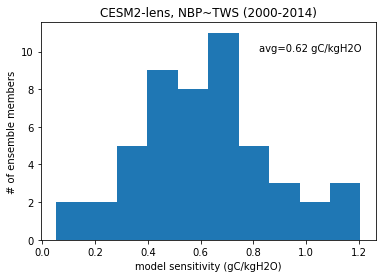

In [83]:
mvals = [out[0] for out in regressions]
plt.hist(mvals);
plt.xlabel('model sensitivity (gC/kgH2O)')
plt.ylabel('# of ensemble members')
plt.title('CESM2-lens, NBP~TWS (2000-2014)');
plt.text(0.82,10,'avg='+str(np.round(np.mean(mvals),2))+' gC/kgH2O');

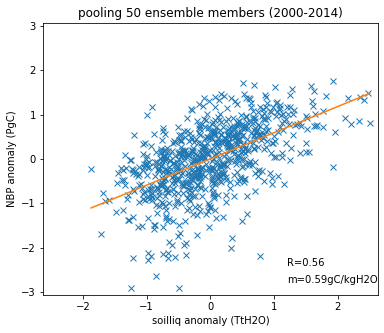

In [71]:
## pool all years together
nx = len(xdt)
ny = len(xdt[0])
x = np.zeros(nx*ny)
y = np.zeros(nx*ny)
for ee in range(nx):
    ix = ee*ny+np.arange(ny)
    x[ix] = xdt[ee]
    y[ix] = ydt[ee]
    
m,r,xfit,yfit = regress(x,y)
xlim = 1.05*max(abs(x))
ylim = 1.05*max(abs(y))
plt.figure(figsize=[6,5])
plt.plot(x,y,'x')
plt.plot(xfit,yfit)
plt.text(1.2,-2.8,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(1.2,-2.4,'R='+str(np.round(r,2)))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.xlim([-xlim,xlim])
plt.ylim([-ylim,ylim])
plt.title('pooling 50 ensemble members (2000-2014)');

In [84]:
1+1

2

In [7]:
def get_file(ee,model,field):
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        yrs    = ['.200001-200912.','.201001-201412.']
        ff     = [glob.glob(mm+lnd+'*.'+field+yy+'*')[0] for yy in yrs]
    return ff